## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp031'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

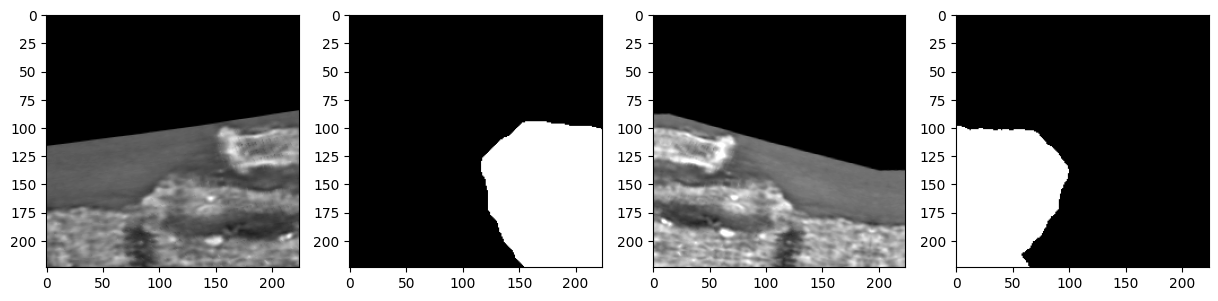

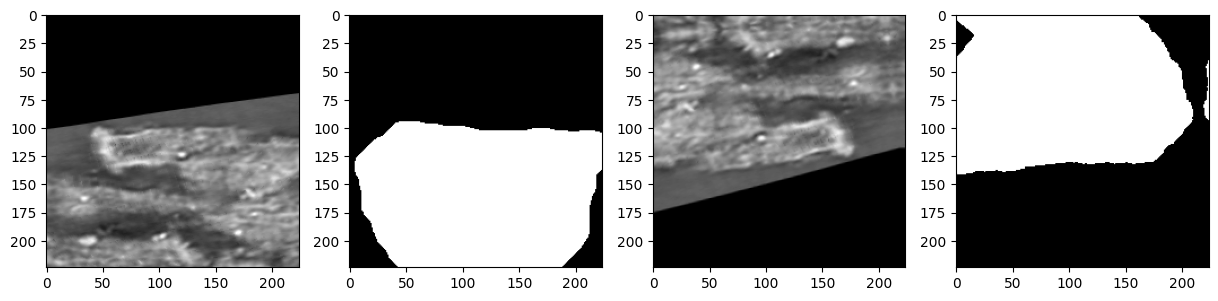

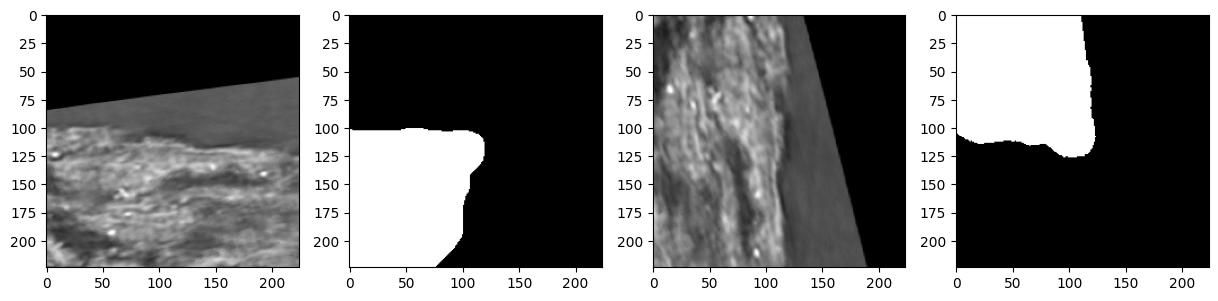

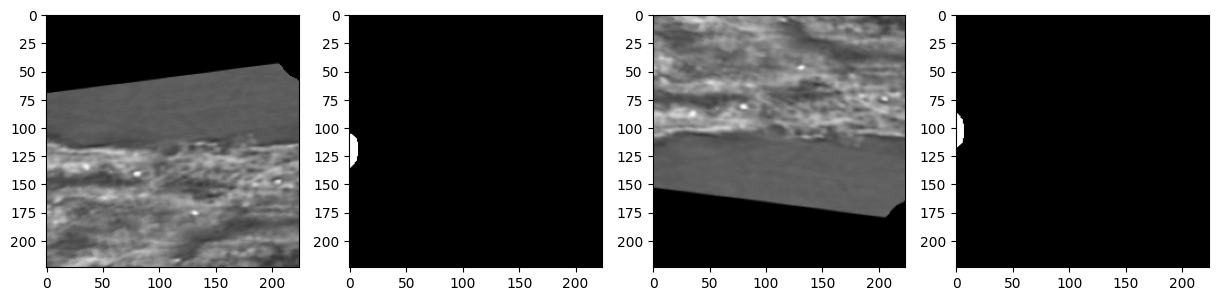

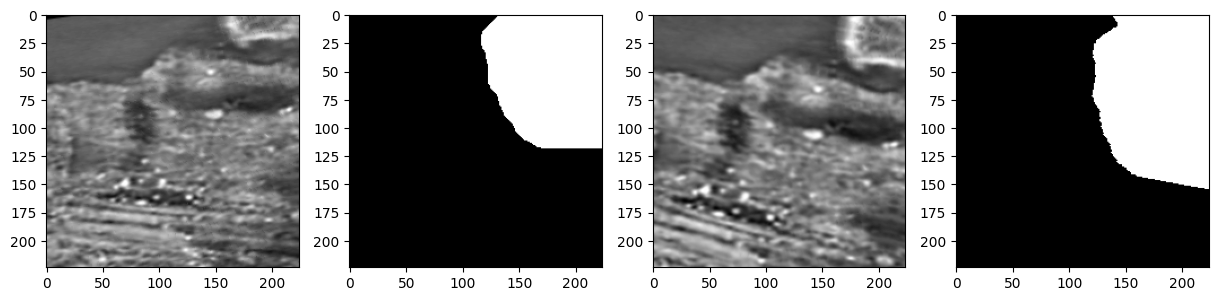

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53895

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    # return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1420888222256902
th: 0.15, fbeta: 0.1420658453372376
th: 0.2, fbeta: 0.14197416981954564
th: 0.25, fbeta: 0.1420801998782021
th: 0.3, fbeta: 0.1948733279944168
th: 0.35, fbeta: 0.2155361153498886
th: 0.4, fbeta: 0.22950671201093506
th: 0.45, fbeta: 0.2423546623693623


best_th: 0.5, fbeta: 0.25164101658297544
Epoch 1 - avg_train_loss: 0.7606  avg_val_loss: 0.6003  time: 116s
Epoch 1 - avgScore: 0.2516
Epoch 1 - Save Best Score: 0.2516 Model
Epoch 1 - Save Best Loss: 0.6003 Model


th: 0.5, fbeta: 0.25164101658297544


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1420928903916175
th: 0.15, fbeta: 0.1420875692541209
th: 0.2, fbeta: 0.14637039038156277
th: 0.25, fbeta: 0.20741766262566363
th: 0.3, fbeta: 0.2387166975346069
th: 0.35, fbeta: 0.2685031935220812
th: 0.4, fbeta: 0.30037652525773245
th: 0.45, fbeta: 0.32350714063435904


best_th: 0.5, fbeta: 0.32939585946937083
Epoch 2 - avg_train_loss: 0.6523  avg_val_loss: 0.5452  time: 118s
Epoch 2 - avgScore: 0.3294
Epoch 2 - Save Best Score: 0.3294 Model
Epoch 2 - Save Best Loss: 0.5452 Model


th: 0.5, fbeta: 0.32939585946937083


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.30195518418361056
th: 0.15, fbeta: 0.3499117348941495
th: 0.2, fbeta: 0.36152645200183076
th: 0.25, fbeta: 0.3589084865441431
th: 0.3, fbeta: 0.3496846304947312
th: 0.35, fbeta: 0.33446978886591194
th: 0.4, fbeta: 0.3129837099079484
th: 0.45, fbeta: 0.287203932274342


best_th: 0.2, fbeta: 0.36152645200183076
Epoch 3 - avg_train_loss: 0.5258  avg_val_loss: 0.5050  time: 119s
Epoch 3 - avgScore: 0.3615
Epoch 3 - Save Best Score: 0.3615 Model
Epoch 3 - Save Best Loss: 0.5050 Model


th: 0.5, fbeta: 0.25685248794348564


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3073270228897063
th: 0.15, fbeta: 0.2929956232619334
th: 0.2, fbeta: 0.27616264488763465
th: 0.25, fbeta: 0.2584440226437406
th: 0.3, fbeta: 0.24261920889365163
th: 0.35, fbeta: 0.22480882546695125
th: 0.4, fbeta: 0.20759775553911977
th: 0.45, fbeta: 0.18724879451511456


best_th: 0.1, fbeta: 0.3073270228897063
Epoch 4 - avg_train_loss: 0.4259  avg_val_loss: 0.5714  time: 117s
Epoch 4 - avgScore: 0.3073


th: 0.5, fbeta: 0.1672184500731893


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3906924589270045
th: 0.15, fbeta: 0.3761354610867276
th: 0.2, fbeta: 0.3585186188785046
th: 0.25, fbeta: 0.3378555357682455
th: 0.3, fbeta: 0.3180033729082228
th: 0.35, fbeta: 0.296115607359138
th: 0.4, fbeta: 0.2707356577102534
th: 0.45, fbeta: 0.24608437091288005


best_th: 0.1, fbeta: 0.3906924589270045
Epoch 5 - avg_train_loss: 0.3870  avg_val_loss: 0.5633  time: 116s
Epoch 5 - avgScore: 0.3907
Epoch 5 - Save Best Score: 0.3907 Model
Epoch 5 - Save Best Loss: 0.5633 Model


th: 0.5, fbeta: 0.22200304445423674


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3578336488968938
th: 0.15, fbeta: 0.3372392161178463
th: 0.2, fbeta: 0.314061756906529
th: 0.25, fbeta: 0.2878768583505833
th: 0.3, fbeta: 0.266905957557724
th: 0.35, fbeta: 0.24969254610716027
th: 0.4, fbeta: 0.22950342660130982
th: 0.45, fbeta: 0.2063709416839091


best_th: 0.1, fbeta: 0.3578336488968938
Epoch 6 - avg_train_loss: 0.3587  avg_val_loss: 0.6199  time: 117s
Epoch 6 - avgScore: 0.3578


th: 0.5, fbeta: 0.18090583385932443


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39604941247029296
th: 0.15, fbeta: 0.3984346436822649
th: 0.2, fbeta: 0.40120596749665743
th: 0.25, fbeta: 0.4029009109840726
th: 0.3, fbeta: 0.40023566685130896
th: 0.35, fbeta: 0.39705002320825705
th: 0.4, fbeta: 0.3922598124536259
th: 0.45, fbeta: 0.38485085135204644


best_th: 0.25, fbeta: 0.4029009109840726
Epoch 7 - avg_train_loss: 0.3385  avg_val_loss: 0.5667  time: 117s
Epoch 7 - avgScore: 0.4029
Epoch 7 - Save Best Score: 0.4029 Model
Epoch 7 - Save Best Loss: 0.5667 Model


th: 0.5, fbeta: 0.3727620644513522


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34840896652464887
th: 0.15, fbeta: 0.34229600501298607
th: 0.2, fbeta: 0.33548120913939095
th: 0.25, fbeta: 0.32203158828039147
th: 0.3, fbeta: 0.3051847329084746
th: 0.35, fbeta: 0.29374996533718933
th: 0.4, fbeta: 0.28170875299546705
th: 0.45, fbeta: 0.26449498871086946


best_th: 0.1, fbeta: 0.34840896652464887
Epoch 8 - avg_train_loss: 0.3364  avg_val_loss: 0.5876  time: 117s
Epoch 8 - avgScore: 0.3484


th: 0.5, fbeta: 0.24263220181681525


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25643869884413734
th: 0.15, fbeta: 0.23397885692356793
th: 0.2, fbeta: 0.2103442294916898
th: 0.25, fbeta: 0.18196169329601417
th: 0.3, fbeta: 0.16039451502627267
th: 0.35, fbeta: 0.1447233869639641
th: 0.4, fbeta: 0.12734044037961606
th: 0.45, fbeta: 0.10719817026822934


best_th: 0.1, fbeta: 0.25643869884413734
Epoch 9 - avg_train_loss: 0.3096  avg_val_loss: 0.6946  time: 117s
Epoch 9 - avgScore: 0.2564


th: 0.5, fbeta: 0.08491785372263343


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3520589391386932
th: 0.15, fbeta: 0.34201019108104175
th: 0.2, fbeta: 0.3313432968378128
th: 0.25, fbeta: 0.3116996852155017
th: 0.3, fbeta: 0.29147639988633145
th: 0.35, fbeta: 0.27688215656148263
th: 0.4, fbeta: 0.26290444881606534
th: 0.45, fbeta: 0.24651529584833942


best_th: 0.1, fbeta: 0.3520589391386932
Epoch 10 - avg_train_loss: 0.2869  avg_val_loss: 0.6568  time: 116s
Epoch 10 - avgScore: 0.3521


th: 0.5, fbeta: 0.22421156708204118


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27504744703645884
th: 0.15, fbeta: 0.25782477232036854
th: 0.2, fbeta: 0.23570496588967957
th: 0.25, fbeta: 0.20781842108351592
th: 0.3, fbeta: 0.18713907598385038
th: 0.35, fbeta: 0.17259323313586927
th: 0.4, fbeta: 0.15649032819803202
th: 0.45, fbeta: 0.13560132468314834


best_th: 0.1, fbeta: 0.27504744703645884
Epoch 11 - avg_train_loss: 0.2856  avg_val_loss: 0.6730  time: 116s
Epoch 11 - avgScore: 0.2750


th: 0.5, fbeta: 0.10655196788214187


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2589059927988348
th: 0.15, fbeta: 0.2419560307934162
th: 0.2, fbeta: 0.22104412532474388
th: 0.25, fbeta: 0.18187222048321017
th: 0.3, fbeta: 0.15175302875827362
th: 0.35, fbeta: 0.1375416319052976
th: 0.4, fbeta: 0.12409045289698178
th: 0.45, fbeta: 0.10591557203576588


best_th: 0.1, fbeta: 0.2589059927988348
Epoch 12 - avg_train_loss: 0.2741  avg_val_loss: 0.7302  time: 116s
Epoch 12 - avgScore: 0.2589


th: 0.5, fbeta: 0.08085134655362071


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3789890779541067
th: 0.15, fbeta: 0.37313844040145444
th: 0.2, fbeta: 0.3663450524887682
th: 0.25, fbeta: 0.35348605185696347
th: 0.3, fbeta: 0.3387666194338353
th: 0.35, fbeta: 0.3272095353559728
th: 0.4, fbeta: 0.31628872920015105
th: 0.45, fbeta: 0.3010123290268478


best_th: 0.1, fbeta: 0.3789890779541067
Epoch 13 - avg_train_loss: 0.2426  avg_val_loss: 0.6754  time: 117s
Epoch 13 - avgScore: 0.3790


th: 0.5, fbeta: 0.2706355154953296


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3781642304867402
th: 0.15, fbeta: 0.37366572176688884
th: 0.2, fbeta: 0.367236722185186
th: 0.25, fbeta: 0.35135329308097474
th: 0.3, fbeta: 0.3307131614887403
th: 0.35, fbeta: 0.3175036839709106
th: 0.4, fbeta: 0.3049982913687543
th: 0.45, fbeta: 0.28551196402774015


best_th: 0.1, fbeta: 0.3781642304867402
Epoch 14 - avg_train_loss: 0.2293  avg_val_loss: 0.6899  time: 116s
Epoch 14 - avgScore: 0.3782


th: 0.5, fbeta: 0.2509446283805234


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30645981640892284
th: 0.15, fbeta: 0.29029771494754675
th: 0.2, fbeta: 0.2720673670199443
th: 0.25, fbeta: 0.23792002621604255
th: 0.3, fbeta: 0.2127452854301427
th: 0.35, fbeta: 0.19745229412440637
th: 0.4, fbeta: 0.18216162971245292
th: 0.45, fbeta: 0.16079203053364372


best_th: 0.1, fbeta: 0.30645981640892284
Epoch 15 - avg_train_loss: 0.2119  avg_val_loss: 0.7690  time: 119s
Epoch 15 - avgScore: 0.3065


th: 0.5, fbeta: 0.12696318854208818


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3696157826095481
th: 0.15, fbeta: 0.36690815156385337
th: 0.2, fbeta: 0.3643004312607579
th: 0.25, fbeta: 0.3528064015663863
th: 0.3, fbeta: 0.3389963779984268
th: 0.35, fbeta: 0.33145540009654256
th: 0.4, fbeta: 0.324307842073493
th: 0.45, fbeta: 0.3140549874687057


best_th: 0.1, fbeta: 0.3696157826095481
Epoch 16 - avg_train_loss: 0.2052  avg_val_loss: 0.7030  time: 119s
Epoch 16 - avgScore: 0.3696


th: 0.5, fbeta: 0.28769104231644504


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3144183870505614
th: 0.15, fbeta: 0.30142656714874444
th: 0.2, fbeta: 0.2890182807101019
th: 0.25, fbeta: 0.2648537730836432
th: 0.3, fbeta: 0.24113163433907095
th: 0.35, fbeta: 0.2233677901263186
th: 0.4, fbeta: 0.20701302782520692
th: 0.45, fbeta: 0.18676093305535338


best_th: 0.1, fbeta: 0.3144183870505614
Epoch 17 - avg_train_loss: 0.2052  avg_val_loss: 0.7369  time: 119s
Epoch 17 - avgScore: 0.3144


th: 0.5, fbeta: 0.15530555179973562


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36019614783801684
th: 0.15, fbeta: 0.3567126505989092
th: 0.2, fbeta: 0.3513678134600921
th: 0.25, fbeta: 0.3401336654782783
th: 0.3, fbeta: 0.32431237731012014
th: 0.35, fbeta: 0.31250680072342224
th: 0.4, fbeta: 0.3008695642303485
th: 0.45, fbeta: 0.284717853319413


best_th: 0.1, fbeta: 0.36019614783801684
Epoch 18 - avg_train_loss: 0.1955  avg_val_loss: 0.6870  time: 120s
Epoch 18 - avgScore: 0.3602


th: 0.5, fbeta: 0.25016294615981516


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3522516387462679
th: 0.15, fbeta: 0.34482280057080494
th: 0.2, fbeta: 0.3329794839983723
th: 0.25, fbeta: 0.3133794509234763
th: 0.3, fbeta: 0.29170838692563694
th: 0.35, fbeta: 0.27747274140460004
th: 0.4, fbeta: 0.2624505025186054
th: 0.45, fbeta: 0.24391041627101348


best_th: 0.1, fbeta: 0.3522516387462679
Epoch 19 - avg_train_loss: 0.1996  avg_val_loss: 0.6968  time: 119s
Epoch 19 - avgScore: 0.3523


th: 0.5, fbeta: 0.2153377302798003


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37036947384757896
th: 0.15, fbeta: 0.3676837069481651
th: 0.2, fbeta: 0.36419104788735357
th: 0.25, fbeta: 0.35729755954893777
th: 0.3, fbeta: 0.3394580041585786
th: 0.35, fbeta: 0.3276558991663457
th: 0.4, fbeta: 0.31679969528172447
th: 0.45, fbeta: 0.30327277147800363


best_th: 0.1, fbeta: 0.37036947384757896
Epoch 20 - avg_train_loss: 0.1868  avg_val_loss: 0.7177  time: 118s
Epoch 20 - avgScore: 0.3704


th: 0.5, fbeta: 0.2720287188231659


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3664158265522305
th: 0.15, fbeta: 0.3615342173328125
th: 0.2, fbeta: 0.3550362986851745
th: 0.25, fbeta: 0.33961501151743745
th: 0.3, fbeta: 0.3225632317432874
th: 0.35, fbeta: 0.3105981729107531
th: 0.4, fbeta: 0.2990406749056083
th: 0.45, fbeta: 0.2832627633399137


best_th: 0.1, fbeta: 0.3664158265522305
Epoch 21 - avg_train_loss: 0.1738  avg_val_loss: 0.7316  time: 119s
Epoch 21 - avgScore: 0.3664


th: 0.5, fbeta: 0.24916199016488602


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34978615616298653
th: 0.15, fbeta: 0.34210410353414483
th: 0.2, fbeta: 0.3326863057176842
th: 0.25, fbeta: 0.30769446347254803
th: 0.3, fbeta: 0.28202906613871237
th: 0.35, fbeta: 0.26685054872523467
th: 0.4, fbeta: 0.2528188708703264
th: 0.45, fbeta: 0.23502506162138026


best_th: 0.1, fbeta: 0.34978615616298653
Epoch 22 - avg_train_loss: 0.1686  avg_val_loss: 0.7568  time: 118s
Epoch 22 - avgScore: 0.3498


th: 0.5, fbeta: 0.1967064904433342


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34761172620489983
th: 0.15, fbeta: 0.33910165425155303
th: 0.2, fbeta: 0.3285052926992684
th: 0.25, fbeta: 0.30256111118790374
th: 0.3, fbeta: 0.2760394855984377
th: 0.35, fbeta: 0.25926025137314557
th: 0.4, fbeta: 0.24601832155719602
th: 0.45, fbeta: 0.22764408669940017


best_th: 0.1, fbeta: 0.34761172620489983
Epoch 23 - avg_train_loss: 0.1558  avg_val_loss: 0.7629  time: 117s
Epoch 23 - avgScore: 0.3476


th: 0.5, fbeta: 0.19167045649632594


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35722429522443244
th: 0.15, fbeta: 0.35109143758926586
th: 0.2, fbeta: 0.3442254056335843
th: 0.25, fbeta: 0.32770927058232324
th: 0.3, fbeta: 0.303884497618041
th: 0.35, fbeta: 0.29187143916256986
th: 0.4, fbeta: 0.28172487784523054
th: 0.45, fbeta: 0.26789771301131543


best_th: 0.1, fbeta: 0.35722429522443244
Epoch 24 - avg_train_loss: 0.1597  avg_val_loss: 0.7613  time: 119s
Epoch 24 - avgScore: 0.3572


th: 0.5, fbeta: 0.2304898890758041


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3662513824716079
th: 0.15, fbeta: 0.3622271745304804
th: 0.2, fbeta: 0.35706246685767046
th: 0.25, fbeta: 0.3468277127051618
th: 0.3, fbeta: 0.3290025087741581
th: 0.35, fbeta: 0.31736604405265995
th: 0.4, fbeta: 0.30672148042226804
th: 0.45, fbeta: 0.29098324886136506


best_th: 0.1, fbeta: 0.3662513824716079
Epoch 25 - avg_train_loss: 0.1507  avg_val_loss: 0.7517  time: 118s
Epoch 25 - avgScore: 0.3663


th: 0.5, fbeta: 0.25362548599187623


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34625261098314347
th: 0.15, fbeta: 0.34073038387929805
th: 0.2, fbeta: 0.33307165336193606
th: 0.25, fbeta: 0.31028539643952247
th: 0.3, fbeta: 0.28617881507075915
th: 0.35, fbeta: 0.2724279961521584
th: 0.4, fbeta: 0.25980355834955093
th: 0.45, fbeta: 0.23974299359266962


best_th: 0.1, fbeta: 0.34625261098314347
Epoch 26 - avg_train_loss: 0.1424  avg_val_loss: 0.7892  time: 119s
Epoch 26 - avgScore: 0.3463


th: 0.5, fbeta: 0.19682337034133193


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3696501791912157
th: 0.15, fbeta: 0.36583440741866646
th: 0.2, fbeta: 0.36092047918772713
th: 0.25, fbeta: 0.3482655419161007
th: 0.3, fbeta: 0.33021445483727985
th: 0.35, fbeta: 0.31947598662114796
th: 0.4, fbeta: 0.3098184630528534
th: 0.45, fbeta: 0.2945743015298291


best_th: 0.1, fbeta: 0.3696501791912157
Epoch 27 - avg_train_loss: 0.1450  avg_val_loss: 0.7370  time: 119s
Epoch 27 - avgScore: 0.3697


th: 0.5, fbeta: 0.2518921828729979


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3648306554386191
th: 0.15, fbeta: 0.3618295682116253
th: 0.2, fbeta: 0.3590134716320462
th: 0.25, fbeta: 0.35120191239458104
th: 0.3, fbeta: 0.33544456440057646
th: 0.35, fbeta: 0.3255699700265796
th: 0.4, fbeta: 0.3163426211753797
th: 0.45, fbeta: 0.3009056303947493


best_th: 0.1, fbeta: 0.3648306554386191
Epoch 28 - avg_train_loss: 0.1411  avg_val_loss: 0.7499  time: 119s
Epoch 28 - avgScore: 0.3648


th: 0.5, fbeta: 0.25725833577762486


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3543458599322767
th: 0.15, fbeta: 0.35099949161922545
th: 0.2, fbeta: 0.34588451745927823
th: 0.25, fbeta: 0.33316116854152605
th: 0.3, fbeta: 0.31453458298629833
th: 0.35, fbeta: 0.30327624638965556
th: 0.4, fbeta: 0.29213788176013095
th: 0.45, fbeta: 0.2748098009895183


best_th: 0.1, fbeta: 0.3543458599322767
Epoch 29 - avg_train_loss: 0.1375  avg_val_loss: 0.7602  time: 119s
Epoch 29 - avgScore: 0.3543


th: 0.5, fbeta: 0.23140622206124944


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35020734419391214
th: 0.15, fbeta: 0.3450280322490144
th: 0.2, fbeta: 0.3384087552092373
th: 0.25, fbeta: 0.32093654881469286
th: 0.3, fbeta: 0.29882693682601996
th: 0.35, fbeta: 0.2862878239128346
th: 0.4, fbeta: 0.2738473068176516
th: 0.45, fbeta: 0.2539597751128327


best_th: 0.1, fbeta: 0.35020734419391214
Epoch 30 - avg_train_loss: 0.1380  avg_val_loss: 0.7766  time: 119s
Epoch 30 - avgScore: 0.3502


th: 0.5, fbeta: 0.21070789675590626


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.39604941247029296
th: 0.15, fbeta: 0.3984346436822649
th: 0.2, fbeta: 0.40120596749665743
th: 0.25, fbeta: 0.4029009109840726
th: 0.3, fbeta: 0.40023566685130896
th: 0.35, fbeta: 0.39705002320825705
th: 0.4, fbeta: 0.3922598124536259
th: 0.45, fbeta: 0.38485085135204644


best_th: 0.25, fbeta: 0.4029009109840726


th: 0.5, fbeta: 0.3727620644513522


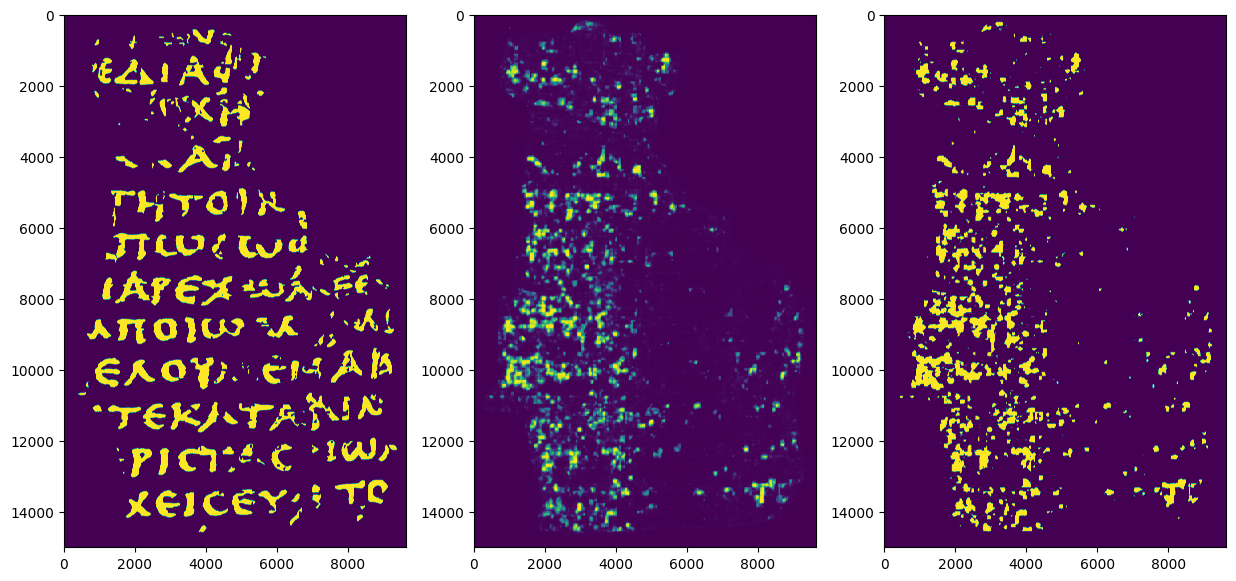

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.25204308e+08, 3.90361400e+06, 1.71147100e+06, 1.58070400e+06,
        1.51152800e+06, 1.22202800e+06, 8.71522000e+05, 8.30041000e+05,
        8.49985000e+05, 9.49793000e+05, 7.87059000e+05, 5.62980000e+05,
        5.45497000e+05, 5.24427000e+05, 4.99077000e+05, 4.17765000e+05,
        4.30551000e+05, 4.79881000e+05, 6.33243000e+05, 1.04158200e+06]),
 array([1.77867383e-04, 5.01683675e-02, 1.00158868e-01, 1.50149368e-01,
        2.00139868e-01, 2.50130368e-01, 3.00120868e-01, 3.50111368e-01,
        4.00101869e-01, 4.50092369e-01, 5.00082869e-01, 5.50073369e-01,
        6.00063869e-01, 6.50054369e-01, 7.00044870e-01, 7.50035370e-01,
        8.00025870e-01, 8.50016370e-01, 9.00006870e-01, 9.49997370e-01,
        9.99987870e-01]),
 <BarContainer object of 20 artists>)

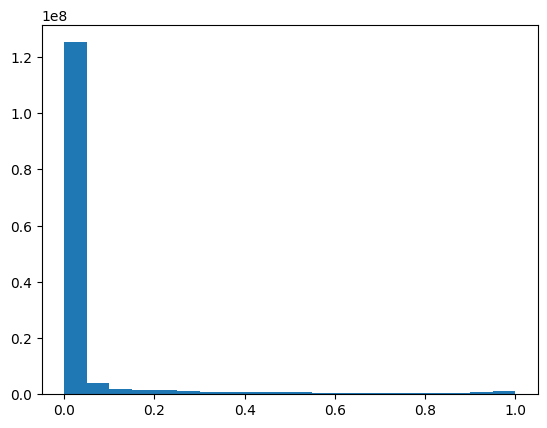

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000